In [1]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
import os
import pdfplumber
from gensim.corpora import Dictionary
from gensim.models import HdpModel
from gensim.models.ldamodel import LdaModel
from sklearn.model_selection import KFold
import pyLDAvis.gensim



# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdlacey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cdlacey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  25


In [3]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 2113
Mean page count per file: 84.52
Median page count per file: 82


In [4]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # Remove specific words or letters which are not useful
    additional_stopwords = {
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"}
    tokens = [token for token in tokens if token not in additional_stopwords]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Directory path containing PDF files
pdf_directory = '/Users/cdlacey/TMU_DataScience/CIND820/Dataset_Sample'

# List all PDF files in the directory
pdf_files = [os.path.join(pdf_directory, file) for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

texts = []

# Loop through each PDF file and extract text
for pdf_file in pdf_files:
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        texts.append(text)

# Preprocess text
preprocessed_texts = [preprocess_text(text) for text in texts]

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


In [5]:
#spliting data for cross validation
from sklearn.model_selection import train_test_split

train_corpus, test_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

In [22]:
# Train the HDP model
hdp_model = HdpModel(train_corpus, id2word=dictionary)

In [23]:
#First evaluation of HDP model and number of topics identified per document)
rows = []

# Iterate through each document in the corpus
for i, doc in enumerate(corpus):
    doc_topics = hdp_model[doc]
    # Extract topic numbers and their probabilities
    topic_numbers = [topic[0] for topic in doc_topics]
    topic_probs = [topic[1] for topic in doc_topics]
    # Append the document's topics to the rows list
    rows.append([i, topic_numbers, topic_probs])

# Create a DataFrame from the list of rows
doc_topics_df = pd.DataFrame(rows, columns=['Document_Index', 'Topic_Numbers', 'Topic_Probabilities'])

# Display the DataFrame
doc_topics_df.head(10)

,Document_Index,Topic_Numbers,Topic_Probabilities
0,0,"[0, 2, 3, 4, 5, 6, 10, 11, 13, 41, 48, 54, 71, 88, 107, 133, 137]","[0.047155762038943436, 0.01745641223716107, 0.021935941002908074, 0.08173593366511456, 0.3656592..."
1,1,[14],[0.9960326922549173]
2,2,"[0, 4]","[0.9826620155469378, 0.016204768081790315]"
3,3,[0],[0.9999601737264474]
4,4,[1],[0.9999840119261535]
5,5,[8],[0.9999438441800745]
6,6,[7],[0.9999496279042555]
7,7,[10],[0.9999406441139107]
8,8,"[0, 2, 4, 8, 10, 13, 14, 60, 66, 83]","[0.3406484096690997, 0.037426905142720464, 0.2210325621217866, 0.12818298433928554, 0.0114204199..."
9,9,[11],[0.9999365625262497]


In [24]:
# To find an approximate number of total topics identified within the HDP model, I found it easiest to train an
#LDA model on the HDP model. 
# Here we'll train an LDA model using the HDP model as a training mechanism
lda_model_t = hdp_model.suggested_lda_model()

# Get the topic distributions for each document
doc_topics = [lda_model_t.get_document_topics(doc) for doc in corpus]

# Count the number of unique topics
unique_topics = set()
for doc_topics in doc_topics:
    unique_topics.update([topic[0] for topic in doc_topics])

num_topics_identified = len(unique_topics)
print(f"Number of topics identified by HDP model: {num_topics_identified}")


Number of topics identified by HDP model: 19


In [9]:
#From the Literature Review, the ideal topics for LDA was found to be 7. 
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(train_corpus, id2word=dictionary, num_topics=7, update_every=1, chunksize=10, passes=10)

In [10]:
#Evaluating LDA topic coherance values.

# Calculate coherence values for each topic
coherence_values = {}
for topic_num in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_num)
    topic_words = [term for term, _ in topic_terms]
    coherence_model = CoherenceModel(topics=[topic_words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.45736087529776065
1	0.874373060072404
2	0.3963513104929659
3	0.660325208683177
4	0.3978611926676396
5	0.5498209228613706
6	0.40954532370489627


In [11]:
# Finding the overall LDA model coherance value
topics = lda_model.show_topics(num_topics=-1, formatted=False)

# Calculate coherence values for each topic
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print("Coherence Score for LDA model:", coherence_lda)

Coherence Score for LDA model: 0.410306025057182


In [25]:
#Evaluating HDP topic coherance values, which were found to have a range below as well as above the LDA model

hdp_topics = hdp_model.show_topics(num_topics=19, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Create a table of coherence values
print("Topic\tCoherence Value")
for topic_num, coherence_value in coherence_values.items():
    print(f"{topic_num}\t{coherence_value}")

Topic	Coherence Value
0	0.35378889730765517
1	0.5815620435360508
2	0.46758620014278823
3	0.3644140581503076
4	0.409021556616043
5	0.23868174880719942
6	0.3441902705045204
7	0.35631095661923473
8	0.4597742834083295
9	0.40607332438045696
10	0.2690057186740486
11	0.4200206196641586
12	0.4300083454633025
13	0.3283835875737579
14	0.3461376859783381
15	0.7456783408159909
16	0.7116339792674294
17	0.7325777676665787
18	0.7453307669425714


In [26]:
# Finding the overall coherhance value for HDP model
hdp_topics = hdp_model.show_topics(num_topics=19, formatted=False)  # Get the top topics

# Extract topic words for each topic
topic_words = [[word for word, _ in topic] for topic_id, topic in hdp_topics]

# Calculate coherence values for each topic
coherence_values = {}
for topic_num, words in enumerate(topic_words):
    coherence_model = CoherenceModel(topics=[words], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_values[topic_num] = coherence_model.get_coherence()

# Compute the average coherence value
avg_coherence_value = sum(coherence_values.values()) / len(coherence_values)

print("Overall Coherence Value for HDP model:", avg_coherence_value)

Overall Coherence Value for HDP model: 0.4584305342904611


In [14]:
#Generate df with dominant topics, the topic contribution and topic keywords for LDA model

def format_topics(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df


df_topic_keywords = format_topics(ldamodel=lda_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0,0.9961,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
1,0,0.9056,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
2,0,0.5588,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
3,0,1.0000,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
4,5,0.9952,"tax, carbon, yea, agre, commonsdeb, mass, nay,...","[common, debat, volum, number, session, parlia..."
5,0,1.0000,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
6,0,1.0000,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
7,0,0.9999,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
8,0,0.9937,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."
9,0,0.6940,"right, work, want, make, need, know, order, li...","[common, debat, volum, number, session, parlia..."


In [15]:
#Generate df of represtative text for dominant topics for LDA model

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format DF
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1.0000,"right, work, want, make, need, know, order, like, support, import","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, novemb, hon..."
1,5,0.9952,"tax, carbon, yea, agre, commonsdeb, mass, nay, sidhu, brison, fraser","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."


In [20]:
#Generate df with dominant topics, the topic contribution and topic keywords for HDP model

def topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize an empty list to store rows
    rows = []

    # Iterate through each document in the corpus
    for i, topics in enumerate(ldamodel[corpus]):
        # Sort topics by contribution
        topics = sorted(topics, key=lambda x: (x[1]), reverse=True)

        # Extract dominant topic, its contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(topics):
            if j == 0:  # Dominant topic
                topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
                row_data = [int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]]
                rows.append(row_data)
                break

    # Create df
    topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return topics_df

df_topic_keywords = topics_sentences(ldamodel=hdp_model, corpus=corpus, texts=preprocessed_texts)

df_topic_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,6,0.3377,"elect, ontario, qubec, offic, elector, vote, parliamentari, make, chief, voter, young, britishco...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
1,8,0.9960,"thedeputyspeak, pension, plan, chambr, thursday, follow, tabl, excel, messagefromthesen, permiss...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, decemb, h..."
2,7,0.9999,"vessel, amend, work, translat, english, abandon, commonsdeb, make, commun, issu, protect, like, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
3,2,1.0000,"first, nation, commonsdeb, commun, make, right, work, issu, know, order, want, develop, question...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
4,0,1.0000,"tax, need, know, want, work, carbon, make, like, commonsdeb, go, say, agre, get, english, budget...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
5,4,0.9999,"trade, agreement, hondura, privileg, right, countri, import, work, question, want, commonsdeb, f...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, march, hono..."
6,1,1.0000,"commonsdeb, work, order, want, countri, make, need, develop, right, support, say, english, impor...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
7,3,0.6305,"right, want, need, issu, make, care, medic, work, commun, import, decis, know, indigen, court, l...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, januari, ho..."
8,2,0.3875,"first, nation, commonsdeb, commun, make, right, work, issu, know, order, want, develop, question...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, octob, ho..."
9,2,0.9999,"first, nation, commonsdeb, commun, make, right, work, issu, know, order, want, develop, question...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."


In [27]:
#Generate df of represtative text for dominant topics for HDP model

pd.options.display.max_colwidth = 100

topics_sorteddf_mallet = pd.DataFrame()
topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in topics_outdf_grpd:
    topics_sorteddf_mallet = pd.concat([topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1.0000,"tax, need, know, want, work, carbon, make, like, commonsdeb, go, say, agre, get, english, budget...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, june, hon..."
1,1,1.0000,"commonsdeb, work, order, want, countri, make, need, develop, right, support, say, english, impor...","[common, debat, volum, number, session, parliament, offici, report, hansard, tuesday, octob, hon..."
2,2,1.0000,"first, nation, commonsdeb, commun, make, right, work, issu, know, order, want, develop, question...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, novemb, h..."
3,3,1.0000,"right, want, need, issu, make, care, medic, work, commun, import, decis, know, indigen, court, l...","[parliament, session, common, debat, offici, report, hansard, volum, monday, octob, honour, anth..."
4,4,0.9999,"trade, agreement, hondura, privileg, right, countri, import, work, question, want, commonsdeb, f...","[common, debat, volum, number, session, parliament, offici, report, hansard, monday, march, hono..."
5,5,0.9999,"ontario, qubec, resourc, commun, crime, support, parliamentari, develop, project, children, firs...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, novemb, hon..."
6,6,0.9999,"elect, ontario, qubec, offic, elector, vote, parliamentari, make, chief, voter, young, britishco...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
7,7,0.9999,"vessel, amend, work, translat, english, abandon, commonsdeb, make, commun, issu, protect, like, ...","[common, debat, volum, number, session, parliament, offici, report, hansard, friday, februari, h..."
8,8,0.9960,"thedeputyspeak, pension, plan, chambr, thursday, follow, tabl, excel, messagefromthesen, permiss...","[common, debat, volum, number, session, parliament, offici, report, hansard, thursday, decemb, h..."


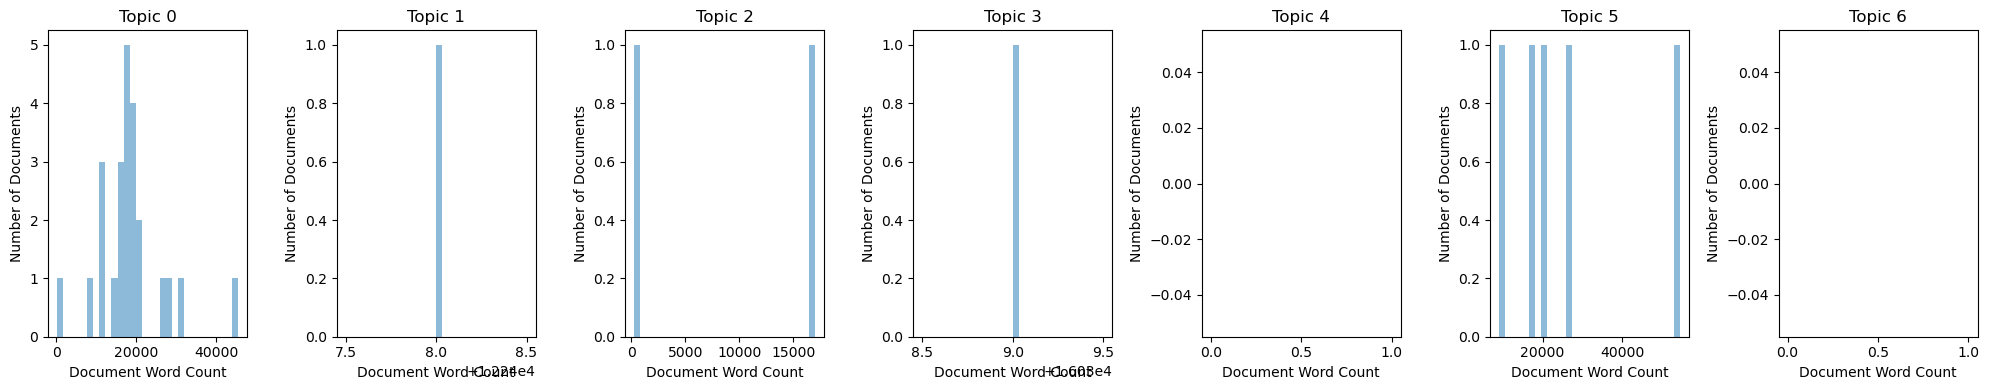

In [28]:
#Ploting document word count against nubmer of documents for LDA model

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 4))

for i in range(7):
    word_counts = []

    
    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda_model.get_document_topics(doc)

        # Check if the current topic is the dominant topic for the document
        for topic, prob in doc_topics:
            if topic == i:
                # Calculate the word count of the document and add it to the list
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    axes[i].hist(word_counts, bins=30, alpha=0.5)
    axes[i].set_title(f'Topic {i}')
    axes[i].set_xlabel('Document Word Count')
    axes[i].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

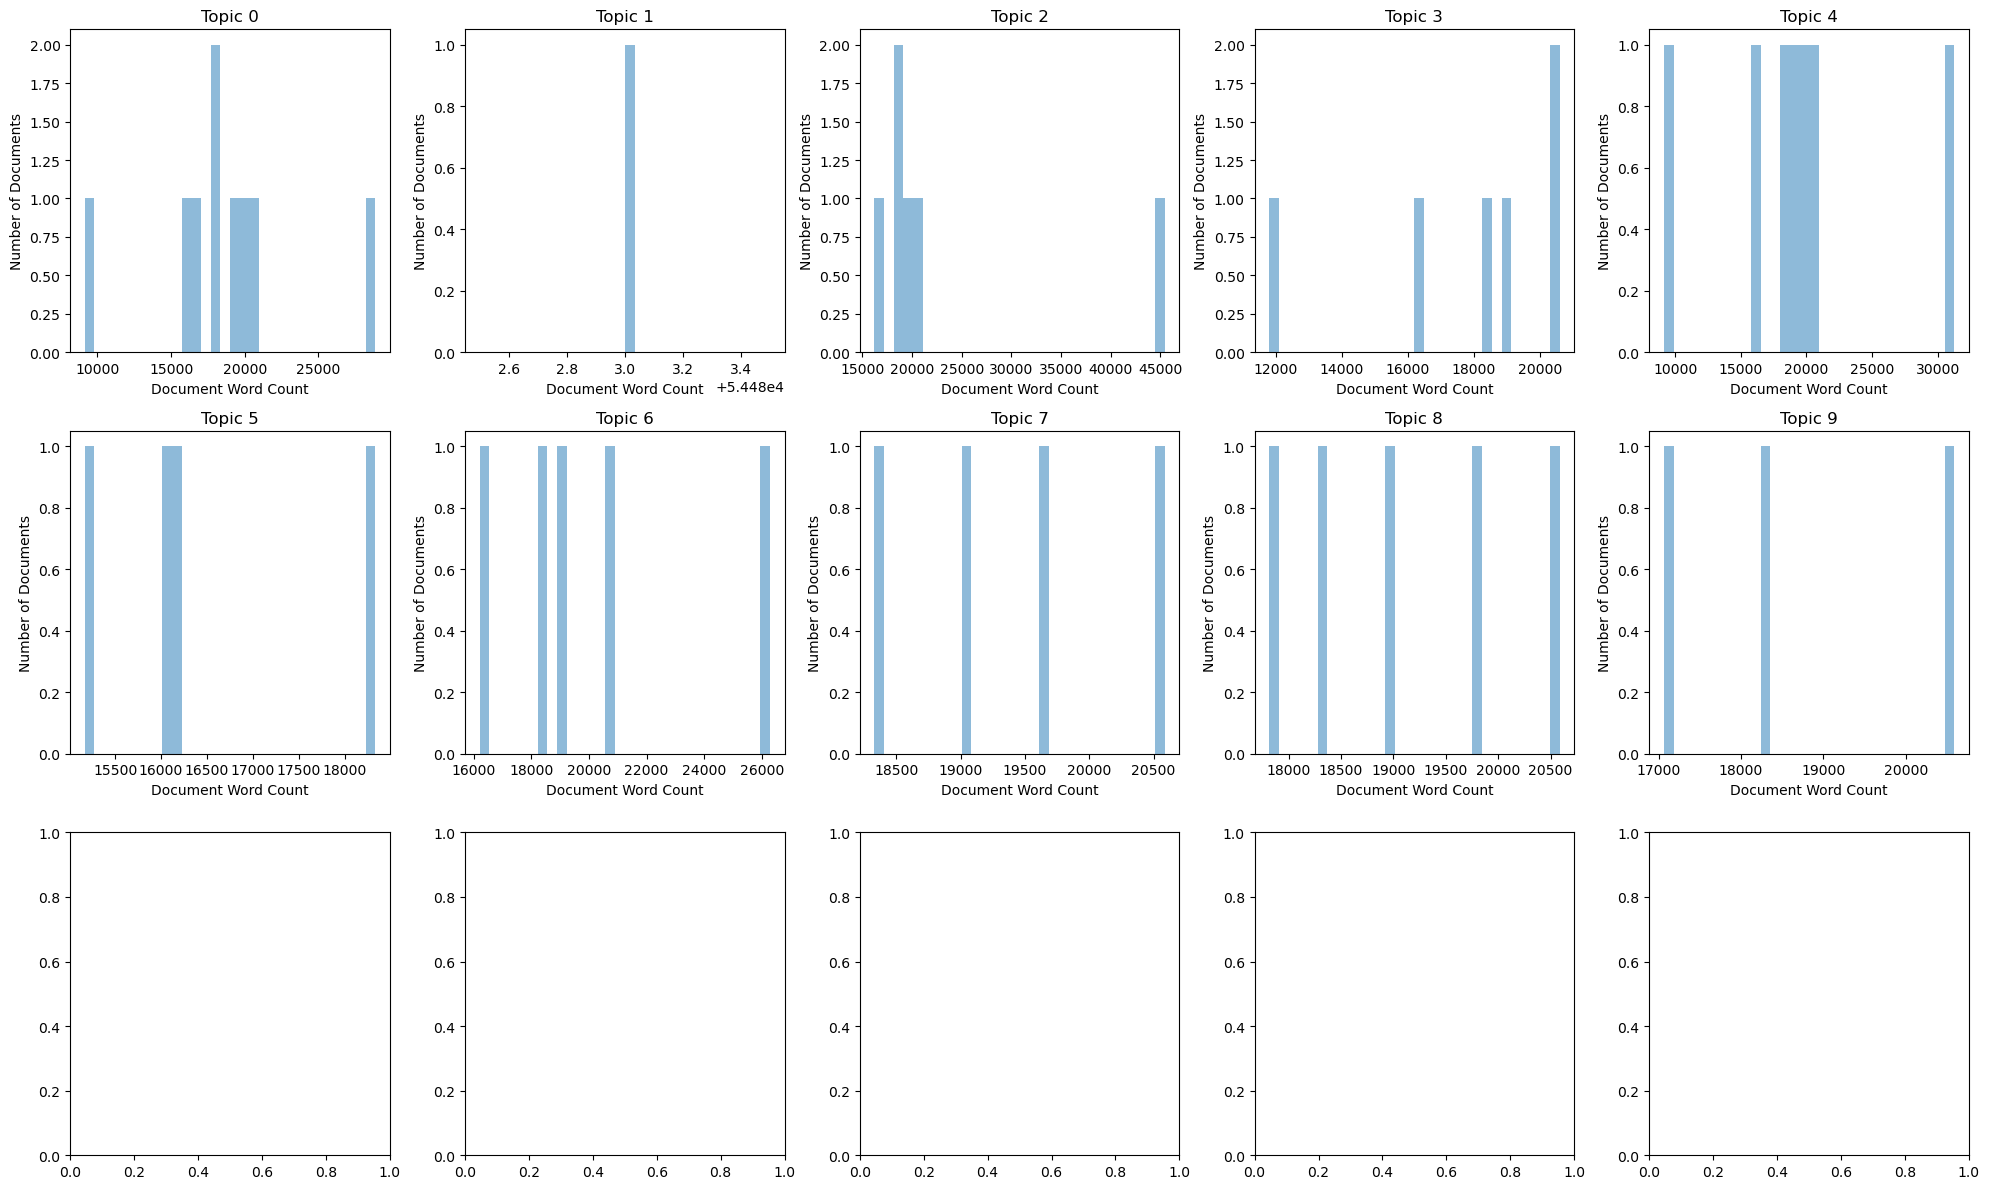

In [29]:
#Ploting document word count against nubmer of documents for HDP model

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))


for i in range(10):
    word_counts = []

    for doc in corpus:
        doc_topics = hdp_model[doc]

        for topic, prob in doc_topics:
            if topic == i:
                word_count = sum(count for _, count in doc)
                word_counts.append(word_count)
                break

    # Determine the position of the subplot in the grid
    row_index = i // 5
    col_index = i % 5

    axes[row_index, col_index].hist(word_counts, bins=30, alpha=0.5)
    axes[row_index, col_index].set_title(f'Topic {i}')
    axes[row_index, col_index].set_xlabel('Document Word Count')
    axes[row_index, col_index].set_ylabel('Number of Documents')

plt.tight_layout()
plt.show()

In [30]:
#Exploring the relevant terms for each topic of the LDA Model

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.276524 -0.103681       1        1  84.900550
5     -0.203626  0.132424       2        1  12.330586
2      0.070782 -0.037497       3        1   1.149755
3      0.111346  0.001216       4        1   0.993027
1      0.111068  0.006196       5        1   0.624564
4      0.093571  0.000679       6        1   0.000759
6      0.093383  0.000663       7        1   0.000759, topic_info=         Term        Freq        Total Category  logprob  loglift
3080   offici  389.000000   389.000000  Default  30.0000  30.0000
2500  languag  229.000000   229.000000  Default  29.0000  29.0000
4256      tax  893.000000   893.000000  Default  28.0000  28.0000
1426   energi  230.000000   230.000000  Default  27.0000  27.0000
3533  product  389.000000   389.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
1991    howev    0.000048   933.801412   Topic7 -11.2834  -5.0013
4830       us    0.000048  1147.169577   Topic7 -11.2843  -5.2079
1586    first    0.000048  1110.186990   Topic7 -11.2854  -5.1763
2676     mani    0.000048   985.559197   Topic7 -11.2858  -5.0577
3921      see    0.000048   861.029836   Topic7 -11.2860  -4.9227

[490 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
11         1  0.998545  aborigin
13277      1  0.558062     accid
13277      2  0.034879     accid
13277      4  0.418547     accid
46661      3  0.952142       ace
...      ...       ...       ...
5193       2  0.046398      year
5193       3  0.001079      year
5212       1  0.969890     youth
5212       2  0.024247     youth
5212       5  0.008082     youth

[596 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 4, 2, 5, 7])

In [31]:
#Exploring the relevant terms for each topic of the HDP Model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(hdp_model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
0      0.371230  0.013673       1        1  1.707877e+01
1      0.396016  0.104112       2        1  1.093157e+01
2      0.488592  0.037145       3        1  1.039495e+01
4      0.471685  0.046725       4        1  1.000239e+01
3      0.384854  0.025212       5        1  7.776052e+00
...         ...       ...     ...      ...           ...
27    -0.039585 -0.000393     146        1  8.160345e-10
45    -0.039036  0.000224     147        1  3.112924e-15
59    -0.039417 -0.000002     148        1  1.899978e-19
110   -0.039797 -0.000155     149        1  8.437599e-35
139   -0.039212  0.000766     150        1  1.571625e-43

[150 rows x 5 columns], topic_info=                              Term          Freq       Total  Category  \
4723                         trade  5.770000e+02  577.000000   Default   
116                      agreement  5.550000e+02  555.000000   Default   
4256                           tax  8.960000e+02  896.000000   Default   
3191                       ontario  6.320000e+02  632.000000   Default   
5342                      privileg  3.690000e+02  369.000000   Default   
...                            ...           ...         ...       ...   
30467                     northbay  4.146671e-44    1.535818  Topic150   
77483  representativesfrompublicag  4.111009e-44    1.619301  Topic150   
9688                       forinst  4.740242e-44   17.664514  Topic150   
4240                        system  5.391253e-44  511.859284  Topic150   
2026                       ibeliev  4.281563e-44    6.180686  Topic150   

       logprob  loglift  
4723   30.0000  30.0000  
116    29.0000  29.0000  
4256   28.0000  28.0000  
3191   27.0000  27.0000  
5342   26.0000  26.0000  
...        ...      ...  
30467  -9.8486   2.8437  
77483  -9.8572   2.7821  
9688   -9.7148   0.5350  
4240   -9.5861  -2.7028  
2026   -9.8166   1.4834  

[9239 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1          1  0.622208  abandon
1          2  0.051851  abandon
1          3  0.025925  abandon
1          4  0.077776  abandon
1          7  0.025925  abandon
...      ...       ...      ...
31551      4  0.418546    yvonn
31551      5  0.069758    yvonn
31551      6  0.348789    yvonn
31551     11  0.139515    yvonn
46632      3  0.973860     zann

[10217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6, 7, 8, 9, 10, 11, 12, 14, 13, 15, 108, 55, 138, 72, 41, 84, 89, 143, 92, 82, 119, 61, 98, 136, 133, 40, 53, 49, 18, 67, 86, 112, 45, 134, 37, 19, 95, 52, 101, 42, 97, 104, 123, 34, 62, 107, 32, 70, 69, 125, 103, 22, 124, 48, 93, 68, 58, 66, 141, 77, 75, 80, 17, 146, 114, 51, 135, 44, 35, 54, 139, 31, 137, 115, 59, 90, 81, 33, 120, 149, 128, 74, 99, 132, 144, 105, 85, 64, 29, 47, 129, 21, 63, 126, 142, 121, 39, 87, 43, 145, 117, 16, 131, 71, 109, 56, 26, 116, 73, 20, 30, 76, 38, 78, 122, 113, 91, 147, 106, 100, 50, 79, 148, 118, 110, 88, 36, 57, 150, 102, 127, 130, 27, 23, 65, 96, 24, 94, 83, 25, 28, 46, 60, 111, 140])